In [1]:
ls

DS_Store                       gitignore                prototypes/
Prototype_Visualization.ipynb  helper/                  results/
README.md                      models/                  src/
cub/                           output_exp_list_np.npy   train_model.py
cub.zip                        output_gt_list_np.npy    trained_models/
data/                          output_list_np.npy
evaluate_model.py              output_pred_list_np.npy


In [ ]:
cd

In [3]:
import zipfile
with zipfile.ZipFile('./cub.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [6]:
import argparse
import math
import os
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from helper import pmath
from helper.helper import get_optimizer, load_dataset
from helper.hyperbolicLoss import PeBusePenalty
from models.cifar import resnet as resnet_cifar
from models.cifar import densenet as densenet_cifar
from models.cub import resnet as resnet_cub
import collections
# t-sne visualize
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

n_components = 2
tsne = TSNE(n_components, random_state=8)
from matplotlib.lines import Line2D

In [7]:
def main_test(model, testloader, initialized_loss, c=1.0):
    # Set model to evaluation and initialize accuracy and cosine similarity.
    model.eval()
    acc = 0
    loss = 0
    
    output_list = []
    output_exp_list = []
    output_gt_list = []
    output_pred_list = []
    
    tsne_x = []
    tsne_y = []
    dict = {}
    
    # Go over all batches.
    with torch.no_grad():
        for data, target in testloader:
            # Data to device.
            data = torch.autograd.Variable(data).cuda() # data: (B x 3 x 224 x 224)
            target = target.cuda(non_blocking=True)
            target = torch.autograd.Variable(target)
            target_loss = model.polars[target]
            
            #output_gt_list.append(target)
            # Forward.
            output = model(data).float() # output: (B x prototype dim) => (B x 312)
            output_tsne = output
            #output_list.append(output)
            output_exp_map = pmath.expmap0(output, c=c) # output_exp_map: (B x prototype dim) => (B x 312)
            #output_exp_list.append(output_exp_map)
            
            output = model.predict(output_exp_map).float() # predict: (B x class num) => (B x 200)
            pred = output.max(1, keepdim=True)[1] # predict: (B x class num) => (B x 1)
            #output_pred_list.append(pred)
            for i in range(len(pred)):
                if pred[i] == target[i]:
                    tsne_x.append(output_tsne[i].tolist())
                    tsne_y.append(target[i].item())
                    
            
            acc += pred.eq(target.view_as(pred)).sum().item()

            loss += initialized_loss(output_exp_map, target_loss.cuda())

    #output_list = torch.cat(output_list, 0)
    #output_exp_list = torch.cat(output_exp_list, 0)
    #output_gt_list = torch.cat(output_gt_list, 0)
    #output_pred_list = torch.cat(output_pred_list, 0)
    
    #print(output_list.size())
    #print(output_exp_list.size())
    #print(output_gt_list.size())
    #print(output_pred_list.size())
    
    #output_list_np = output_list.detach().cpu().numpy()
    #output_exp_list_np = output_exp_list.detach().cpu().numpy()
    #output_gt_list_np = output_gt_list.detach().cpu().numpy()
    #output_pred_list_np = output_pred_list.detach().cpu().numpy()
    
    #np.save("./output_list_np", output_list_np)
    #np.save("./output_exp_list_np", output_exp_list_np)
    #np.save("./output_gt_list_np", output_gt_list_np)
    #np.save("./output_pred_list_np", output_pred_list_np)
    
    print(len(tsne_x), len(tsne_y))
    dict=collections.Counter(tsne_y)
    print(dict)
    
    print("############# visualization #############")
    # 많이 맞춘 10개의 class에 대해서만 visualization
    # 주의 : 실제 class는 +1 ([55, 57, 10, 158, 186, 189, 14, 35, 48, 169])
    #top_10 = [54, 56, 9, 157, 185, 188, 13, 34, 47, 168]
    # 주의 : 실제 class는 +1 ([189, 109, 70, 74, 83, 192, 200, 73, 139, 169])
    top_10 = [188, 108, 69, 73, 82, 191, 199, 72, 138, 168]
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple']
    top_color_dict = {}
    for i in range(len(top_10)):
        top_color_dict[top_10[i]] = colors[i]

    legend_elements_top = []
    for i in range(len(colors)):
        legend_elements_top.append(Line2D([0], [0], marker='o', color=colors[i], label=top_10[i]+1,
                              markerfacecolor=colors[i], markersize=15))
    
    plt.clf()
    plt.figure(figsize=(16,16))
    top_tsne_x = []
    top_tsne_y = []
    example_num = 0

    for i in range(len(tsne_y)):
        if tsne_y[i] in top_10:
            example_num += 1
            top_tsne_x.append(tsne_x[i])
            top_tsne_y.append(tsne_y[i])

    x_2d = tsne.fit_transform(top_tsne_x)

    for i in range(len(x_2d)):
        a = plt.scatter(x_2d[i][0], x_2d[i][1], label=top_tsne_y[i],
                   c = top_color_dict[top_tsne_y[i]])

    print("feature num: " + str(example_num))
    plt.xlim(-40, 40)
    plt.ylim(-40, 40)
    plt.legend(handles=legend_elements_top, loc='upper left')
    plt.show()
    # Print results.
    
    testlen = len(testloader.dataset)

    avg_acc = acc / float(testlen)
    avg_loss = loss / float(testlen)
    

    return avg_acc, avg_loss

100
First time model initialization. Complete!
~~~~~~~~!Your option is not available, I am choosing!~~~~~~~~
model name:  trained_models/best_accuracy_prototype2_2038.pt
epoch: 2038, test_acc: 0.4004142216085606, test_loss: tensor(0.0548, device='cuda:0')
2268 2268
Counter({188: 26, 108: 24, 69: 22, 73: 22, 82: 22, 191: 22, 199: 22, 72: 21, 138: 21, 168: 21, 175: 21, 187: 21, 14: 20, 41: 20, 163: 20, 47: 19, 49: 19, 54: 19, 55: 19, 68: 19, 74: 19, 158: 19, 185: 19, 9: 18, 15: 18, 16: 18, 56: 18, 87: 18, 94: 18, 139: 18, 147: 18, 173: 18, 176: 18, 189: 18, 25: 17, 27: 17, 53: 17, 88: 17, 96: 17, 132: 17, 133: 17, 161: 17, 165: 17, 190: 17, 34: 16, 110: 16, 131: 16, 179: 16, 50: 15, 51: 15, 76: 15, 80: 15, 97: 15, 146: 15, 153: 15, 159: 15, 160: 15, 162: 15, 67: 14, 79: 14, 81: 14, 92: 14, 95: 14, 105: 14, 157: 14, 166: 14, 194: 14, 11: 13, 60: 13, 84: 13, 86: 13, 91: 13, 93: 13, 122: 13, 137: 13, 184: 13, 0: 12, 6: 12, 37: 12, 45: 12, 46: 12, 52: 12, 109: 12, 121: 12, 125: 12, 150: 12, 

<Figure size 432x288 with 0 Axes>

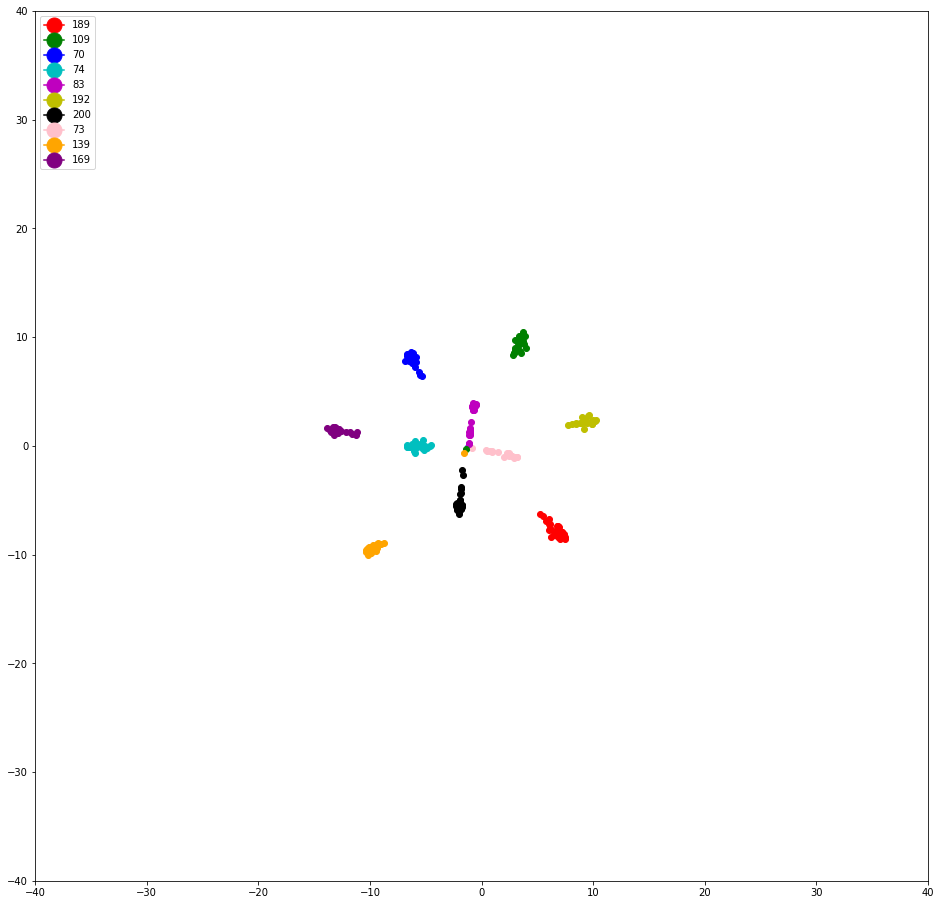

############## test time ##############
epoch: 0, loss: tensor(0.0051, device='cuda:0'), acc: 0.391439420089748


In [8]:
# user parameters and set device.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda")
#kwargs = {'num_workers': 32, 'pin_memory': True}
kwargs = {'num_workers': 8, 'pin_memory': True}

curv = 1.0 # default: 1.0
do_decay = False # default: False

# Set the random seeds.
seed = 100
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Load data.
data_name = "cub"
datadir = "./"
batch_size = 128
trainloader, testloader = load_dataset(data_name, datadir, batch_size, kwargs)


# Load the polars and update the trainy labels.
#hpnfile = "prototypes/prototypes-50d-100c.npy"
#hpnfile = "prototypes/prototypes-312d-200c.npy"
hpnfile = "prototypes/prototypes-100d-200c.npy"

classpolars = torch.from_numpy(np.load(hpnfile)).float()

# calculate radius of ball
# This part is useful when curvature is not 1.
curvature = curv
radius = 1.0 / math.sqrt(curvature)
classpolars = classpolars * radius

# hpnfile name is like prototypes-xd-yc.npy : x : dimension of prototype, y: number of classes
output_dims = int(hpnfile.split("/")[-1].split("-")[1][:-1])
print(output_dims)

# Load the model.
network = "resnet32" # default: resnet32

if (data_name == "cifar100") or (data_name == "cifar10"):
    if network == "resnet32":
        model = resnet_cifar.ResNet(32, output_dims, 1, classpolars)
    elif network == "densenet121":
        model = densenet_cifar.DenseNet121(output_dims, classpolars)
    else:
        print('The model you have chosen is not available. I am choosing resnet for you.')
        model = resnet_cifar.ResNet(32, output_dims, 1, classpolars)
elif data_name == "cub":
    if network == "resnet32":
        model = resnet_cub.ResNet34(output_dims, classpolars)
    else:
        print('The model you have chosen is not available. I am choosing resnet for you.')
        model = resnet_cub.ResNet34(output_dims, classpolars)
else:
    raise Exception('Selected dataset is not available.')

model = model.to(device)
print('First time model initialization. Complete!')


# set and load the optimizer.
optimizer = "adam" # default: sgd
learning_rate = 0.0005 # default: 0.01
momentum = 0.9 # default: 0.9
decay = 0.00005 # default: 0.0001

optimizer = get_optimizer(optimizer, model.parameters(), learning_rate, momentum, decay)

# Initialize the loss functions.
penalty = 0.1 # default: dim
mult = 0.1 # default: 0.1

choose_penalty = penalty
f_loss = PeBusePenalty(output_dims, penalty_option=choose_penalty, mult=mult).cuda()


# checkpoint loading
#model_PATH = "trained_models/best_accuracy_prototype_1764.pt"
model_PATH = "trained_models/best_accuracy_prototype2_2038.pt"
checkpoint = torch.load(model_PATH)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
test_loss = checkpoint['val_loss']
test_acc = checkpoint['val_acc']

print("model name: " , model_PATH)
print("epoch: " + str(epoch) + ", test_acc: " + str(test_acc) + ", test_loss: " + str(test_loss))

model = model.to(device)
    
# Main loop.
testscores = []
best_accuracy = 0
learning_rate = learning_rate


#for i in range(epochs):
    # Learning rate decay.
    #if i in [args.drop1, args.drop2] and do_decay:
    #    learning_rate *= 0.1
    #    for param_group in optimizer.param_groups:
    #        param_group['lr'] = learning_rate

    # Train and test.
    #acc, loss = main_train(model, trainloader, optimizer, f_loss, c=curvature)

    # add the train loss to the tensorboard writer
    #writer.add_scalar("Loss/train", loss, i)
    #writer.add_scalar("Accuracy/train", acc, i)
        
####################### test #######################    
test_acc, test_loss = main_test(model, testloader, f_loss, c=curvature)

i = 0
testscores.append([i, test_acc])

print("############## test time ##############")
print("epoch: " + str(i) + ", loss: " + str(test_loss) + ", acc: " + str(test_acc))